# \[03\] Visualize User Events

## Setup Spark Session

for a detailed description what is done here see [01-setup-spark-session.ipynb](01-setup-spark-session.ipynb)


In [76]:
# EVENT_DATA_URL = "s3a://udacity/sparkify/sparkify_event_data.json"
EVENT_DATA_URL = "s3a://udacity-dsnd/sparkify/mini_sparkify_event_data.json"

CLEAN_DATA_URL = EVENT_DATA_URL.replace("/sparkify/", "/sparkify/output/02-cleaned-")

EXECUTOR_INSTANCES = 2
EXECUTOR_MEM = '6g'

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from cryptography.fernet import Fernet
import base64
import socket

!./install-s3-jars.sh

def decrypt(encrypted_text):
    """
    decrypts an encrypted text. The seed (master-password) for decryption is read from the file ".seed.txt"
    
    Input: encrypted_text
    
    Output: the decrypted text. If the text was not encrypted with the same seed, 
            an exception is raised.
    """
    with open('.seed.txt') as f:
        seed = f.read().strip()
    return Fernet(base64.b64encode((seed*32)[:32].encode('ascii')).decode('ascii')).decrypt(encrypted_text.encode('ascii')).decode('ascii')

AWS_ACCESS_KEY_ID='V6ge1JcQpvyYGJjb'
AWS_SECRET_ACCESS_KEY = decrypt('gAAAAABkDFI6865LaVJVgtTYo0aMx9-JTPbTo6cwOUjg5eNNPsZhBDoHbRZ8xuXQT0ImNfvqcecZuoJd1VzYQEpBaxyCnKvosii8O1KeqoL2NwKdKtL_AUfT4eW4dvJVP--VjEvc0gB4')
OWN_IP=socket.gethostbyname(socket.gethostname())
APP_NAME = "Sparkify"
SPARK_MASTER = "spark://bit-spark-master-svc.spark.svc.cluster.local:7077"
S3_HOST = "minio-api-service.minio.svc"

print(f'### SETUP SPARK SESSION "{APP_NAME}"')
spark = SparkSession.builder \
    .master(SPARK_MASTER) \
    .config("spark.jars","/home/jovyan/jars/aws-java-sdk-bundle-1.11.1026.jar,/home/jovyan/jars/hadoop-aws-3.3.2.jar") \
    .config("spark.driver.host", OWN_IP) \
    .config("spark.hadoop.fs.s3a.endpoint", S3_HOST) \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.access.key", AWS_ACCESS_KEY_ID) \
    .config("spark.hadoop.fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY) \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.executor.instances", EXECUTOR_INSTANCES) \
    .config("spark.executor.memory", EXECUTOR_MEM) \
    .appName(APP_NAME).getOrCreate()
print(f"Spark version: {spark.version}")
sc = spark.sparkContext
sc.setLogLevel("WARN")



### SETUP SPARK SESSION "Sparkify"
Spark version: 3.3.2


## Get Clean Data

There are two possibilities, how to get the cleaned data.  
Load the data saved in step [02-data-introspection.ipynb](02-data-introspection.ipynb) or reapply the transformations to the original dataset.  

**Only apply one of both possibilities**

### Possibility 1 - Load cleaned dataset

In [2]:
print(f"### LOAD DATA {CLEAN_DATA_URL}")
df = spark.read.json(CLEAN_DATA_URL)
print(f"### PERSIST")
df_persist = df.persist()
df = df_persist

### LOAD DATA s3a://udacity-dsnd/sparkify/output/02-cleaned-mini_sparkify_event_data.json
### PERSIST df


### Possibility 2 - Load original dataset and Apply Transformations

For a detailed description what is done here see [02-data-introspection.ipynb](02-data-introspection.ipynb)

In [77]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

print(f"### LOAD DATA {EVENT_DATA_URL}")
df = spark.read.json(EVENT_DATA_URL)

def norm_colname(name):
    """
    Input: name which can contain spaces with upper and lowercase letters.
    Output: all spaces replaced with an underscore and all letters converted to lowercase
    """
    return name.replace(' ', '_').lower()

print(f"### DROP UNUSED COLUMNS")
df = df.drop("artist", "auth", "firstName", "lastName", "length", "location", "method", "song", "userAgent")
print(f"### REMOVE EMPTY USERID")
df = df.filter(df.userId != '')
print(f"### ADD ID")
w = Window().orderBy("ts")
df = df.withColumn("id", F.row_number().over(w))
print(f"### VECTORIZE PAGE FEATURES")
page_features = df.groupBy("id").pivot("page").agg(F.lit(1)).na.fill(0)
page_features = page_features.toDF(*(("pg_"+norm_colname(col)) if col!="id" else "id" for col in page_features.columns))
df = df.join(page_features, "id")
print(f"### VECTORIZE LEVEL FEATURE")
df = df.withColumn("paid", (df.level == 'paid').cast('int'))
df = df.drop("level")
print(f"### VECTORIZE GENDER FEATURE")
df = df.withColumn("male", (df.gender == 'M').cast('int'))
df = df.drop("gender")
print(f"### VECTORIZE STATUS FEATURES")
status_features = df.groupBy("id").pivot("status").agg(F.lit(1)).na.fill(0)
status_features = status_features.toDF(*(("status_"+col) if col != "id" else "id" for col in status_features.columns)).drop("status_200")
df = df.join(status_features, "id")
df = df.drop("status")
print(f"### ADD SID")
df_sess_user = df.select("sessionId", "userId").dropDuplicates()
w = Window().orderBy("sessionId", "userId")
df_sess_user = df_sess_user.withColumn("sid", F.row_number().over(w))
df = df.join(df_sess_user, ["sessionId", "userId"])
df_session_start = df.groupBy("sid").agg(F.min("id").alias("id")).drop("sid").withColumn("session_start", F.lit(1).cast("int"))
df = df.join(df_session_start, "id", how="outer").fillna(0)
df = df.drop("sessionId", "itemInSession")
print(f"### PERSIST")
df_persist = df.persist()
df = df_persist

### LOAD DATA s3a://udacity-dsnd/sparkify/mini_sparkify_event_data.json
### DROP UNUSED COLUMNS
### REMOVE EMPTY USERID
### ADD ID
### VECTORIZE PAGE FEATURES
### VECTORIZE LEVEL FEATURE
### VECTORIZE GENDER FEATURE
### VECTORIZE STATUS FEATURES
### ADD SID
### PERSIST df


## Imports

Here are all imports which are needed in the cells below.

In [78]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime


## Constants

constants that are used in the cells below

In [79]:
# timestamp constants for ts in milliseconds
one_day =      24*60*60*1000  #    86.400.000
one_week =   7*24*60*60*1000  #   604.800.000
one_month = 28*24*60*60*1000  # 2.419.200.000

## Define Pageevent Display

For the visualization we need to define how each page-event should be visualized.  
The value given in "y" will be used as height (Y-axis) do display the event in the given color.  
The height of events is groupd by functionality.
Error is at the bottom and has red color. We expect that hitting the error page more often will force the user to churn. Thus as color "red" was selected.  
Then there are static page views: Home/Help/About. For Help the color orange was chosen, because it might be relevant how often a user asked for help before churning.  
...  
And the last two events Submit-Downgrade/Cancellation-Confirmation are the churning events we want to predict, colored in red:   

In [80]:
pageevent_display = {
 'Error':                     {'y': 5, 'color': 'red'},

 'Home':                      {'y': 10, 'color': 'gray'},
 'Help':                      {'y': 11, 'color': 'orange'},
 'About':                     {'y': 12, 'color': 'gray'},

 'Login':                     {'y': 14, 'color': 'gray'},
 'Logout':                    {'y': 15, 'color': 'gray'},
    
 'Settings':                  {'y': 17, 'color': 'gray'},
 'Save Settings':             {'y': 18, 'color': 'gray'},
 'Add Friend':                {'y': 19, 'color': 'blue'},

 'Thumbs Down':               {'y': 22, 'color': 'orange'},
 'Thumbs Up':                 {'y': 23, 'color': 'blue'},
 'Add to Playlist':           {'y': 24, 'color': 'blue'},
 'NextSong':                  {'y': 25, 'color': 'gray'},

 'Roll Advert':               {'y': 27, 'color': 'gray'},

 'Register':                  {'y': 30, 'color': 'yellow'},
 'Upgrade':                   {'y': 31, 'color': 'yellow'},

 'Submit Registration':       {'y': 34, 'color': 'green'},
 'Submit Upgrade':            {'y': 35, 'color': 'green'},

 'Downgrade':                 {'y': 38, 'color': 'orange'},
 'Cancel':                    {'y': 39, 'color': 'orange'},

 'Submit Downgrade':          {'y': 42, 'color': 'red'},
    
 'Cancellation Confirmation': {'y': 44, 'color': 'red'},

}

## Select interesting users

To find relevant users we count the number of churns for each user  
and select users with many churns, users with exactly one churn and users without any churn.  
For each group we will do a visualization


In [81]:
df_order = df.groupBy("userId").agg(F.count("id").alias("events"), F.sum("pg_submit_downgrade").alias("downs"), F.sum("pg_cancellation_confirmation").alias("cancels")).withColumn("churns", F.col("downs")+F.col("cancels")).sort(F.desc(F.col("churns")))
df_order.show(10)

+------+------+-----+-------+------+
|userId|events|downs|cancels|churns|
+------+------+-----+-------+------+
|   140|  6880|    3|      0|     3|
|    39|  9632|    3|      0|     3|
|200003|   977|    2|      0|     2|
|    35|  2005|    2|      0|     2|
|    54|  3437|    1|      1|     2|
|   131|  1863|    2|      0|     2|
|    85|  4370|    2|      0|     2|
|100025|   623|    1|      1|     2|
|    61|  1976|    2|      0|     2|
|100009|   671|    1|      1|     2|
+------+------+-----+-------+------+
only showing top 10 rows



In [82]:
print(f"total number of users: {df_order.count()}")

top_churning_users = [row.userId for row in df_order.take(6)]
print(f"top churning users {top_churning_users}")
churning_once_users = [row.userId for row in df_order.where((F.col("cancels")==0)&(F.col("downs")==1)).take(3)]
churning_once_users = [*[row.userId for row in df_order.where((F.col("cancels")==1)&(F.col("downs")==0)).take(3)], *churning_once_users]
print(f"churning once users {churning_once_users}")
never_churned_users = [row.userId for row in df_order.where(F.col("churns")==0).take(6)]
print(f"never churned users {never_churned_users}")


total number of users: 225
top churning users ['140', '39', '61', '85', '35', '100025']
churning once users ['53', '200017', '58', '11', '30', '59']
never churned users ['93', '40', '200005', '44', '144', '115']


## Event-Plotting functions

The functions below will display all events in a chronolgical order as a scatter plot  
with the height and color configured above in pageevent_display.  

For a given userId two diagrams are plotted.  
The first diagram displays all events equally distributes over the X-Axis,
while the second diagram displays the event relative to their timestamp.

So, in the first diagram the events are better to see and in the second diagram the sessions are visible.

In [83]:
%matplotlib inline

def get_user_events(userId):
    """
    Input: userId
    Output: dataframe with the list of events for this user ordered by timestamp
    """
    return df.where(df.userId == userId).sort("ts").select("ts", "page").collect()
    
def millis2date(millis):
    """
    Input: timestamp in millisecond format
    Output: string in format "YYYY-MM-DD"
    """
    return datetime.datetime.fromtimestamp(millis/1000.0).strftime("%Y-%m-%d")
    
def plot_user_events(userId):
    """
    Input: userId
    Output: Plots two diagrams of the user events.
    The first diagram displays all events equally distributes over the X-Axis,
    while the second diagram displays the event relative to the timestamp.
    """
    user_events  = get_user_events(userId)
    y = [page_info[ue.page]["y"] for ue in user_events]
    x1 = np.linspace(0, len(y)-1, len(y))
    ts_list = [int(ue.ts) for ue in user_events]
    first_ts = ts_list[0]
    last_ts = ts_list[-1]
    x2 = [(ts-first_ts)/one_day for ts in ts_list]
    c = [page_info[ue.page]["color"] for ue in user_events]
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.scatter(x1, y, c=c)
    plt.title(f'User {userId}:  ({millis2date(first_ts)} - {millis2date(last_ts)} - {round((last_ts-first_ts)/one_day)} days)')
    plt.xlabel("Event Number");
    plt.yticks([pi["y"] for pi in page_info.values()], list(page_info.keys()), rotation=30)
    plt.show()

    plt.rcParams['figure.figsize'] = [10, 6]
    plt.scatter(x2, y, c=c)
    plt.xlabel("Day");
    plt.yticks([pi["y"] for pi in page_info.values()], list(page_info.keys()), rotation=30)
    plt.show()
    

## Top Users churning multiple times

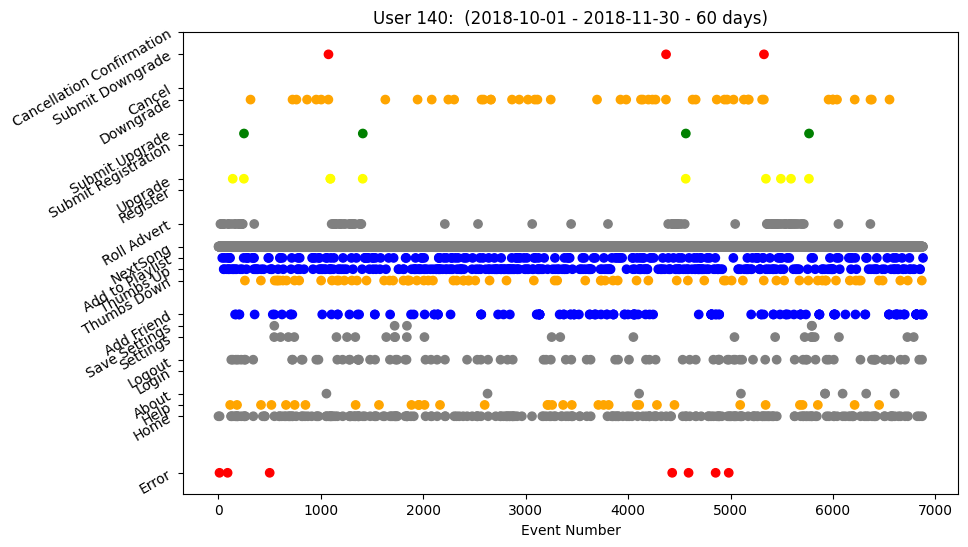

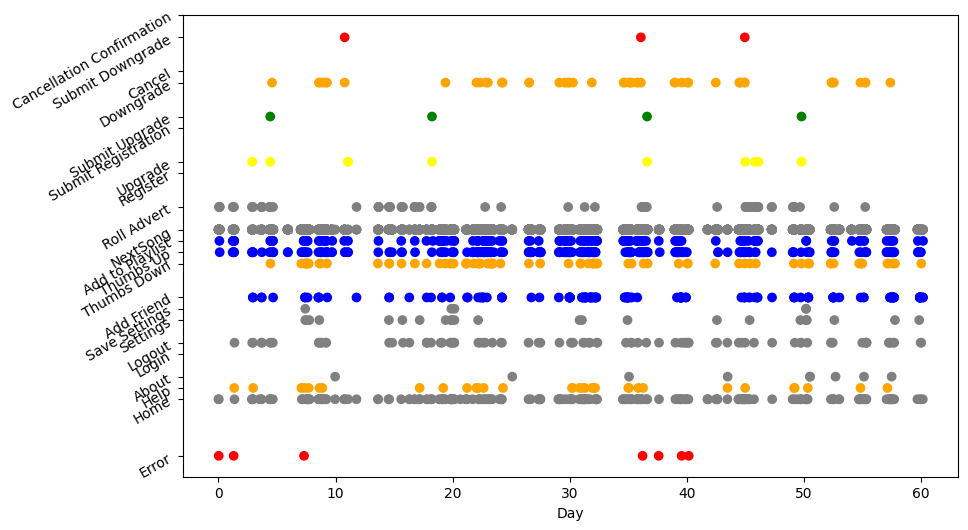

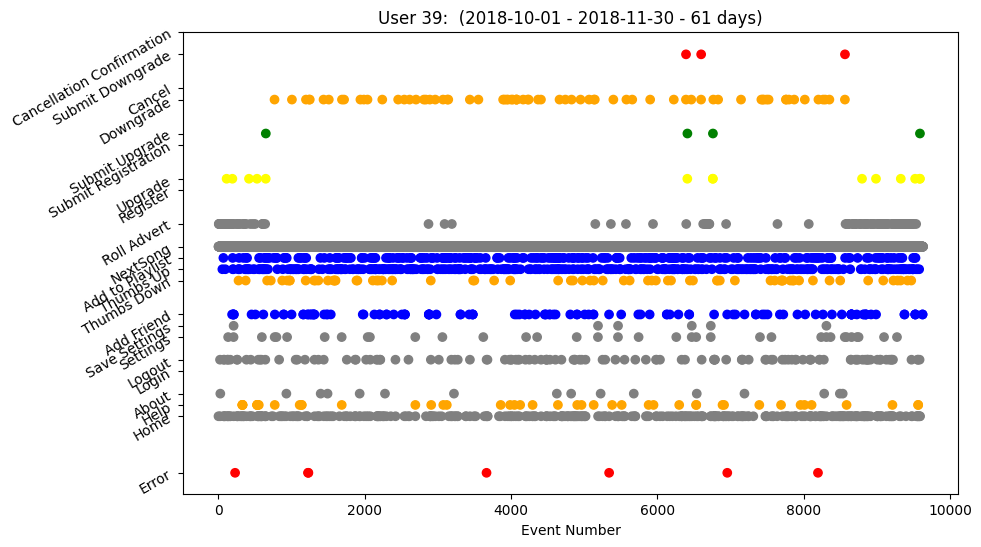

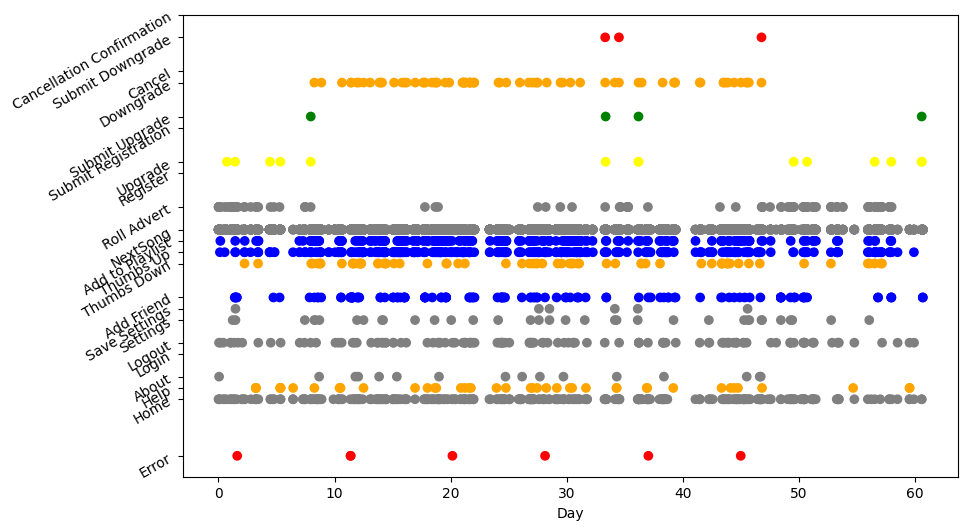

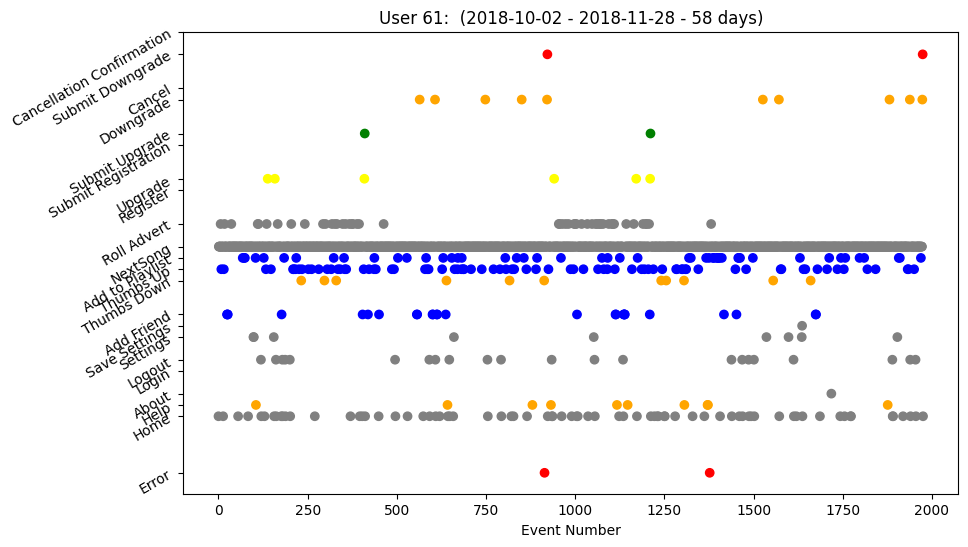

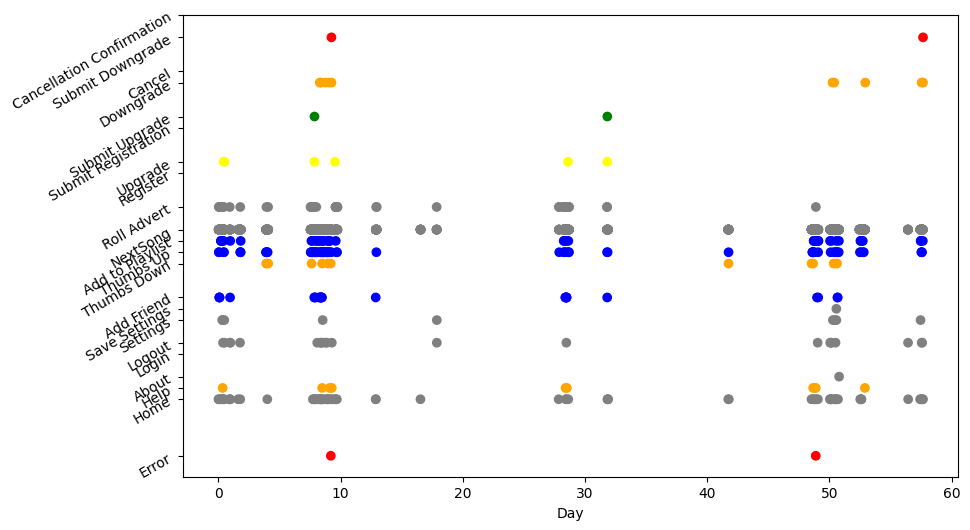

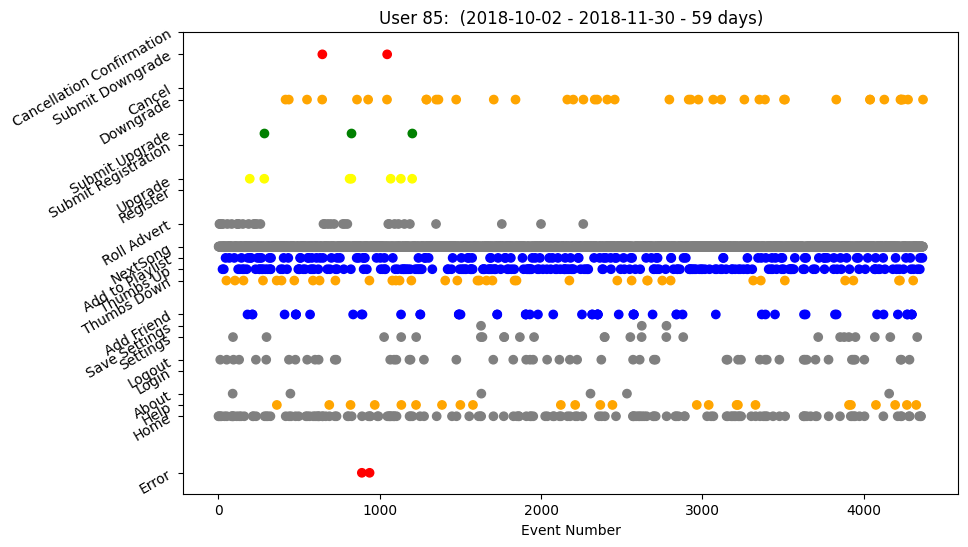

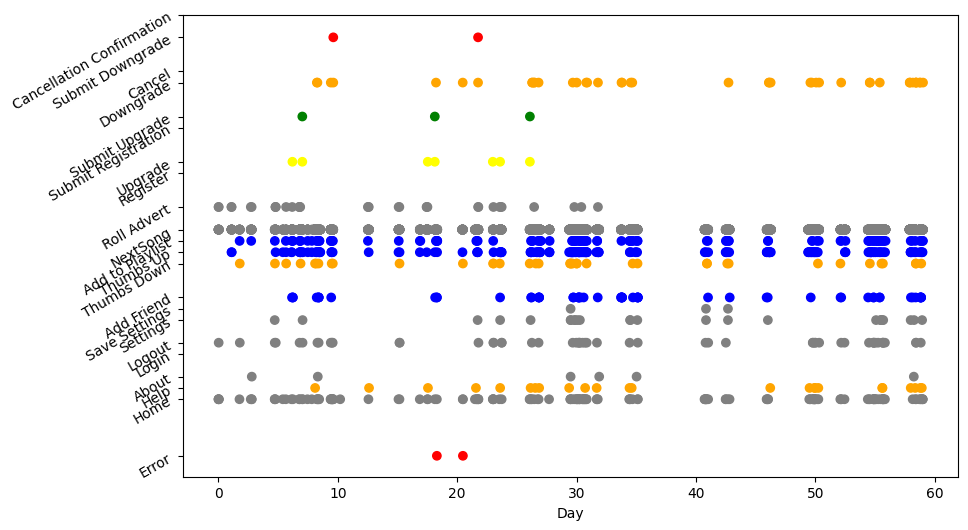

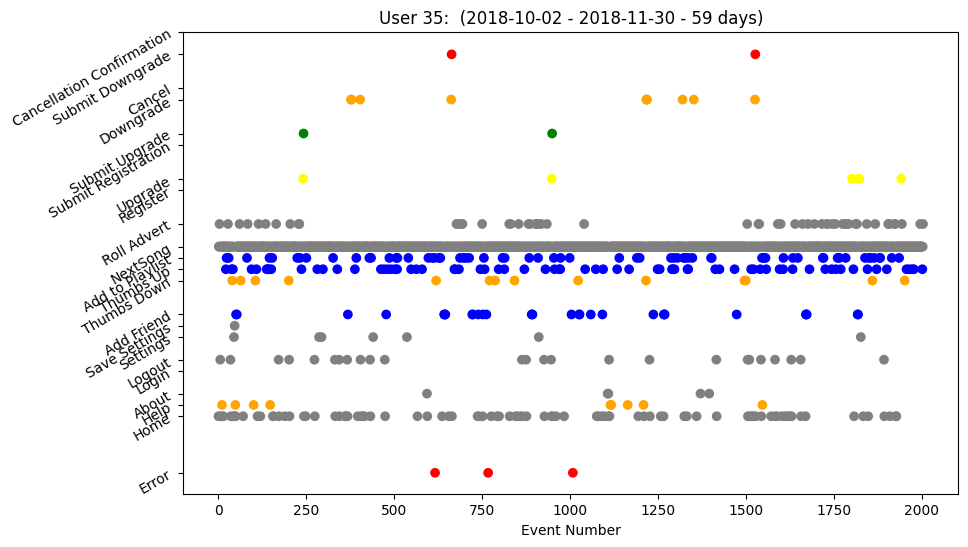

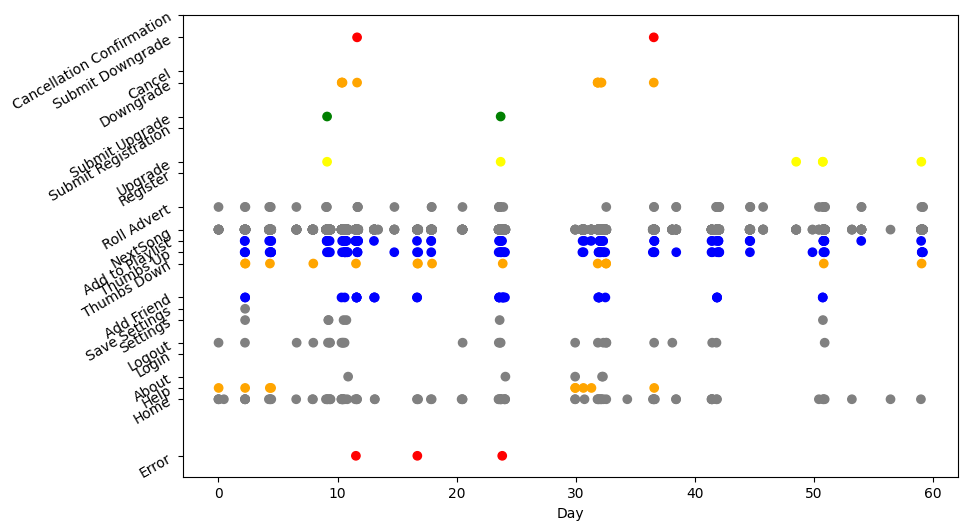

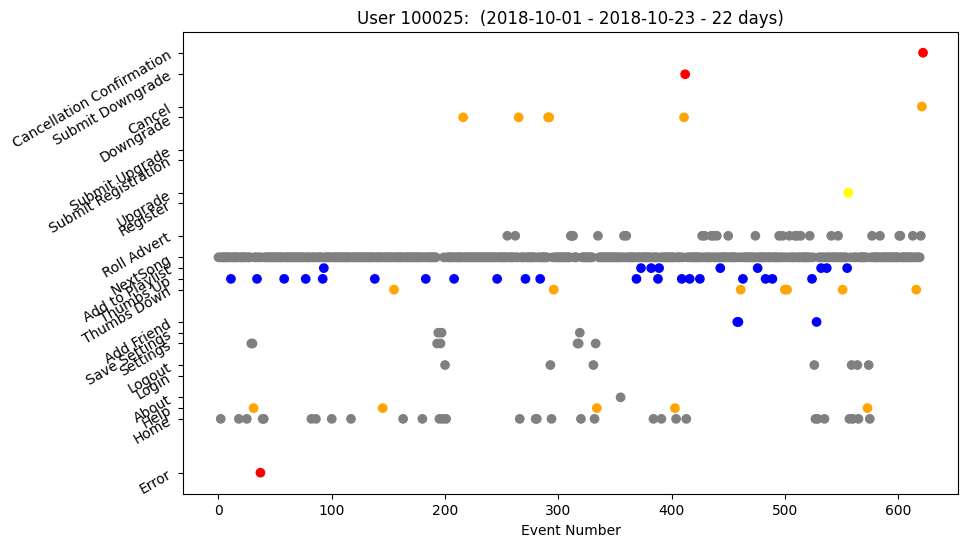

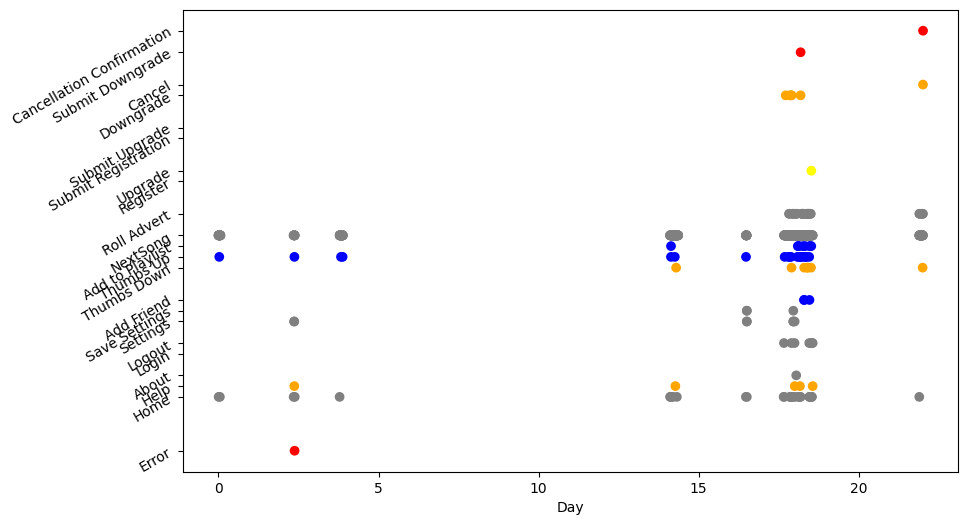

In [84]:
for uid in top_churning_users:
    plot_user_events(uid)

## Users who churned exactly once

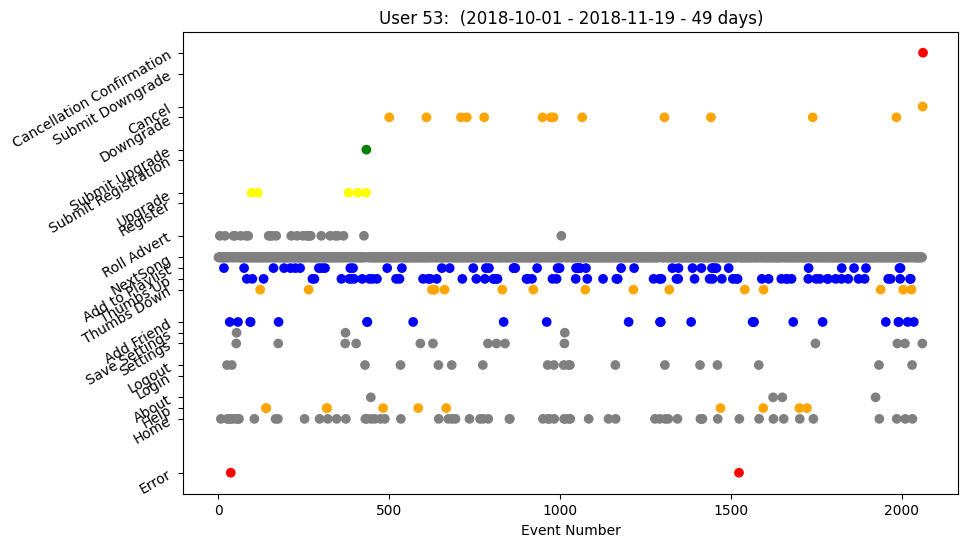

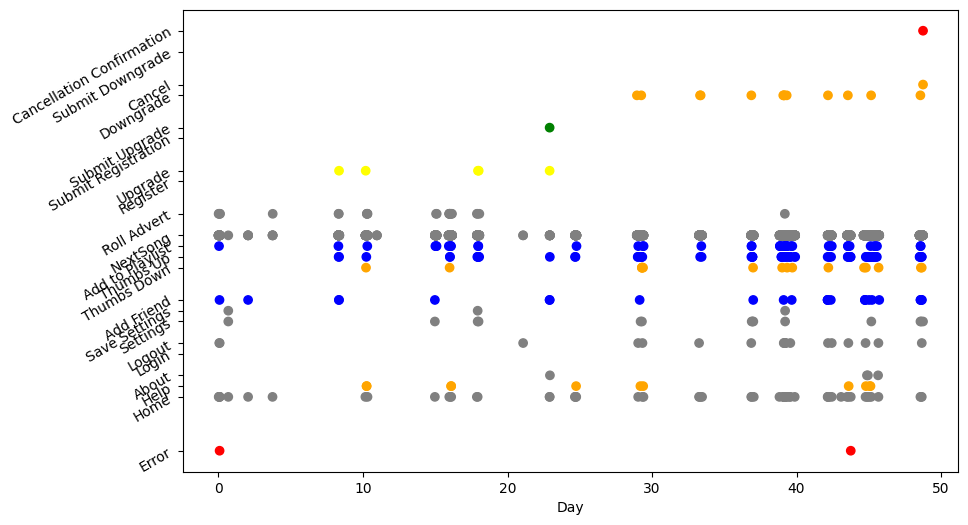

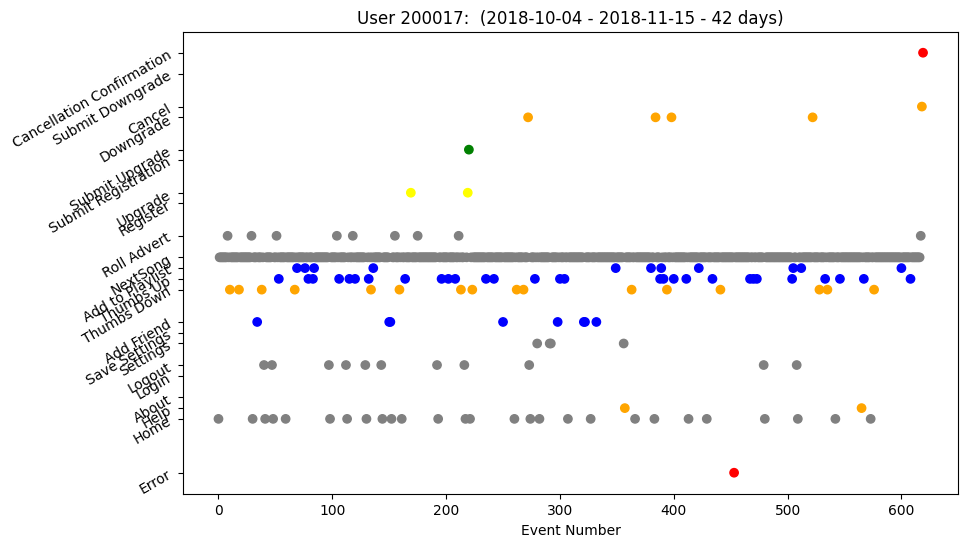

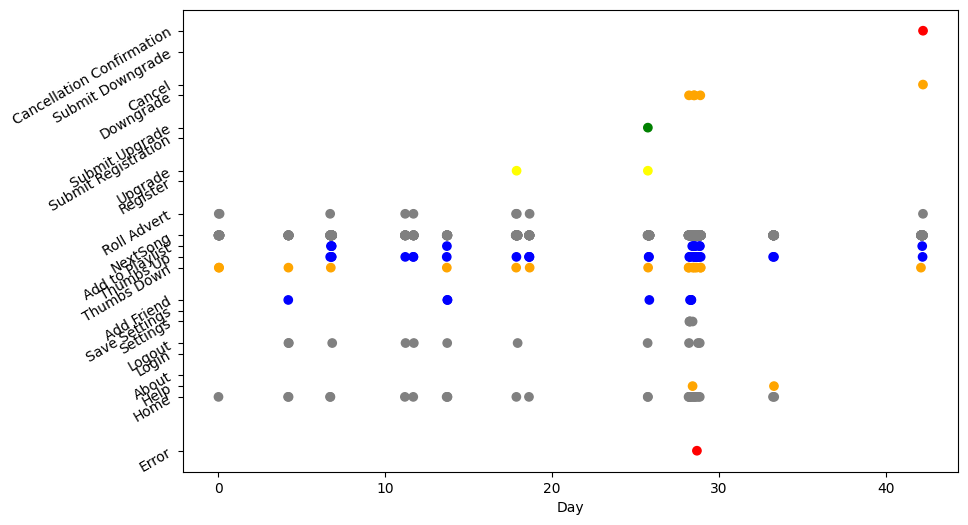

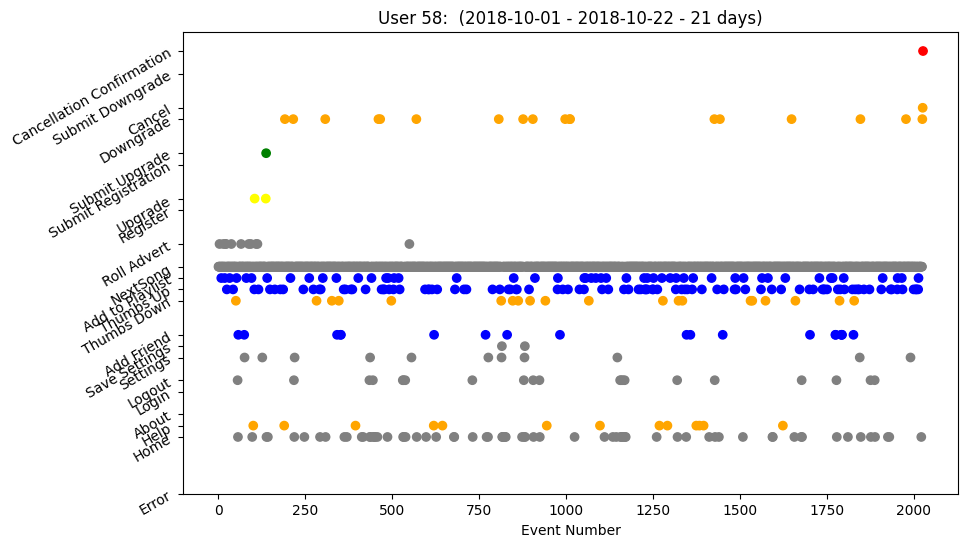

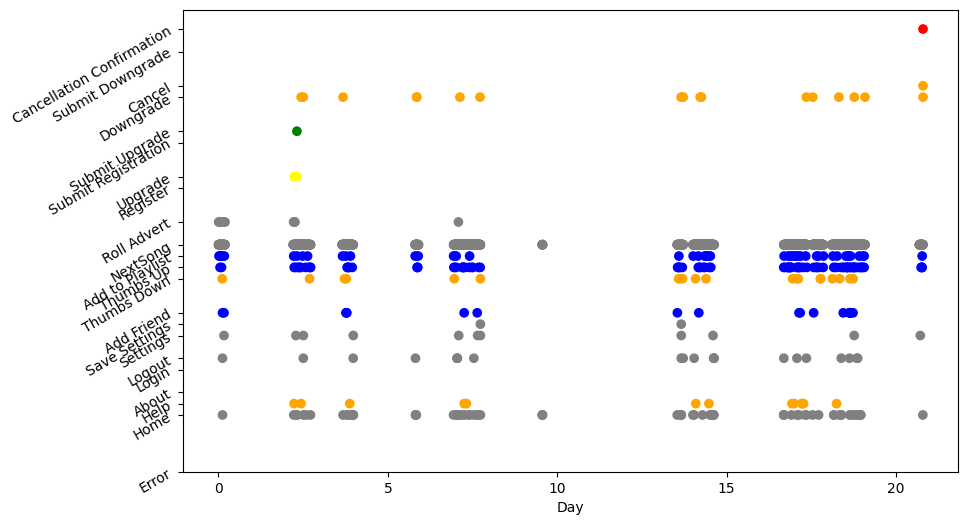

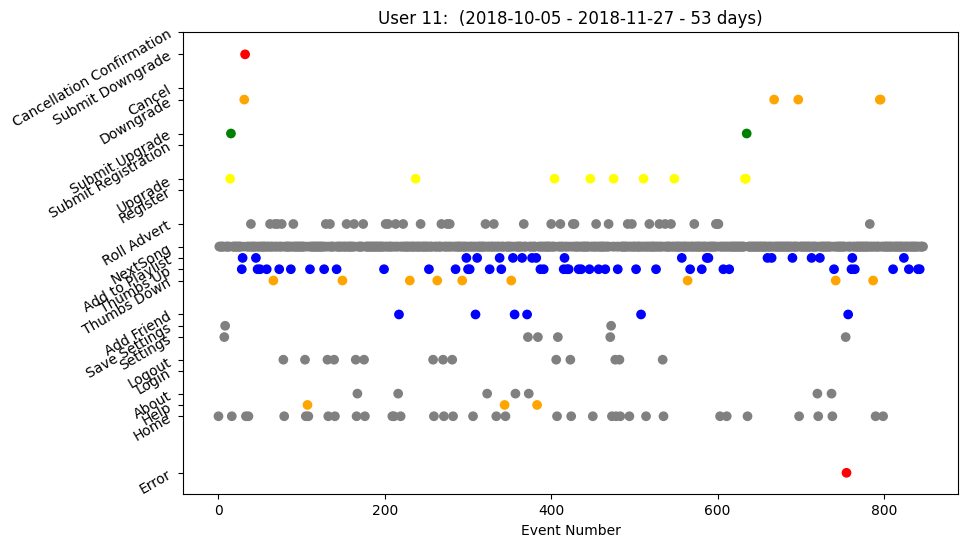

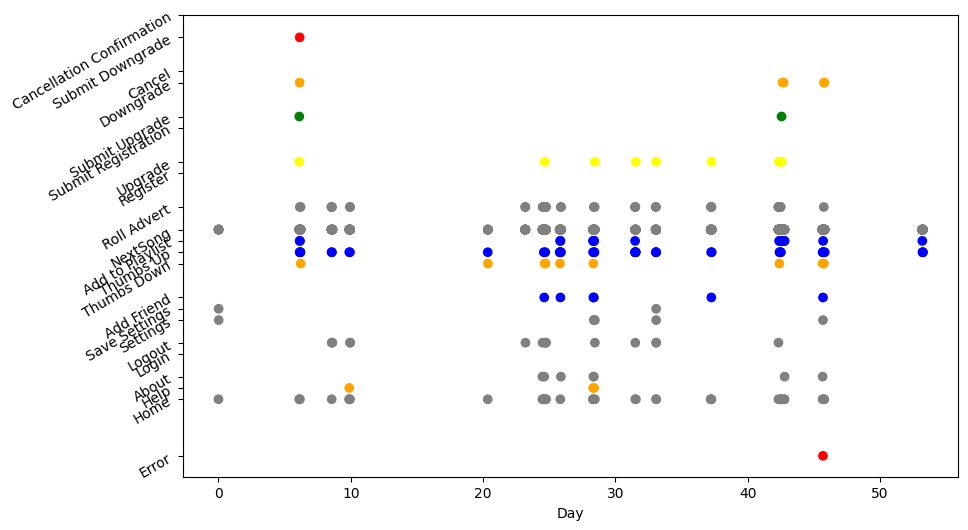

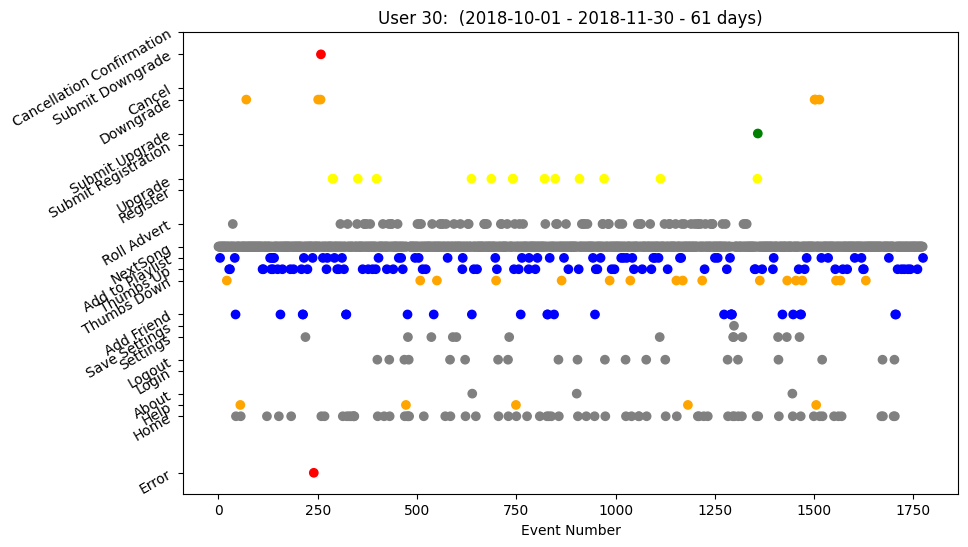

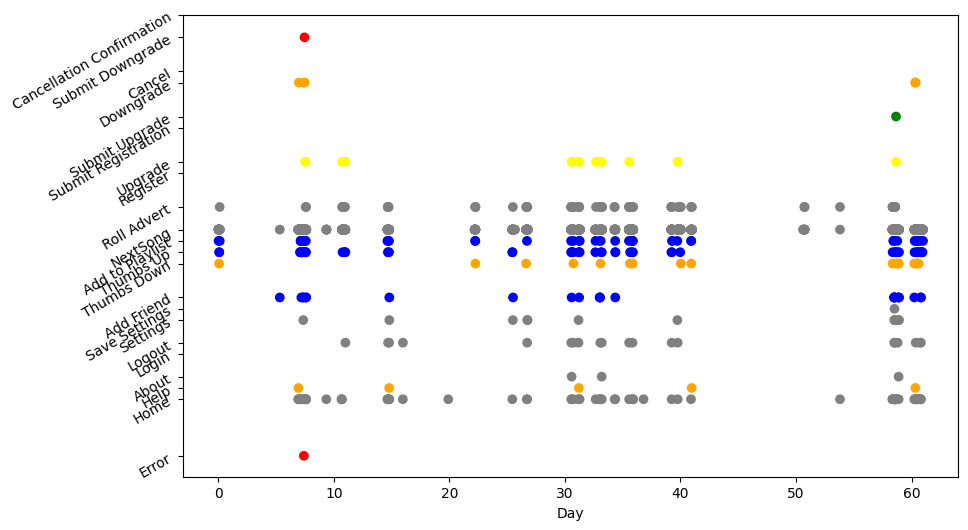

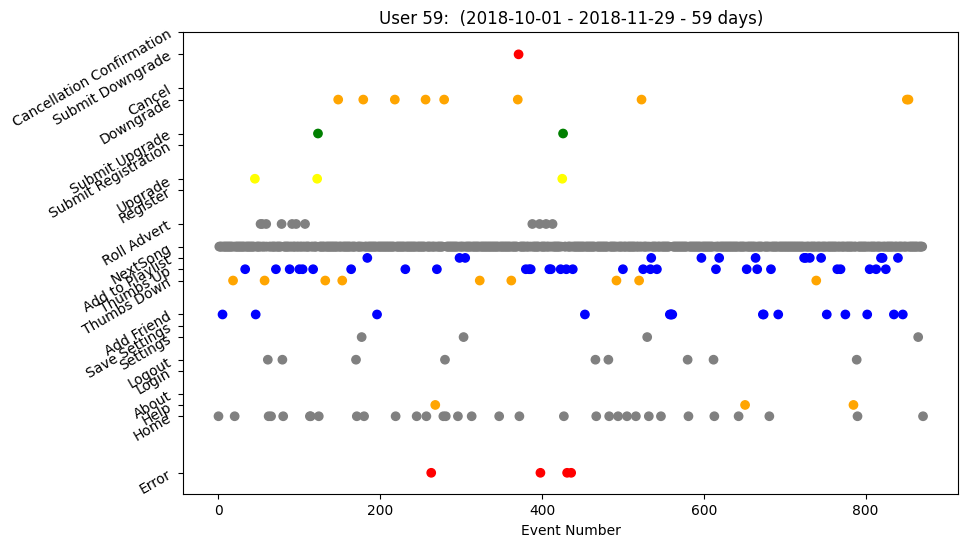

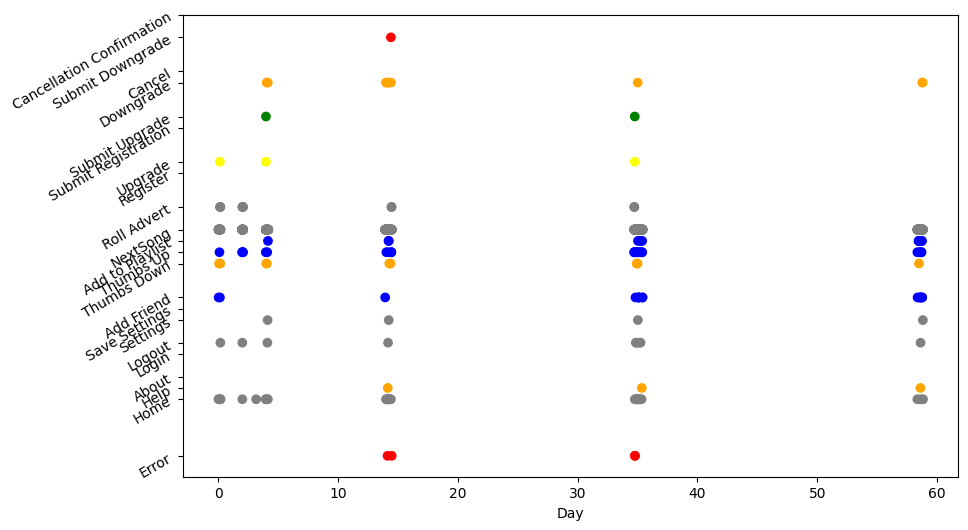

In [85]:
for uid in churning_once_users:
    plot_user_events(uid)

## Users who never churned

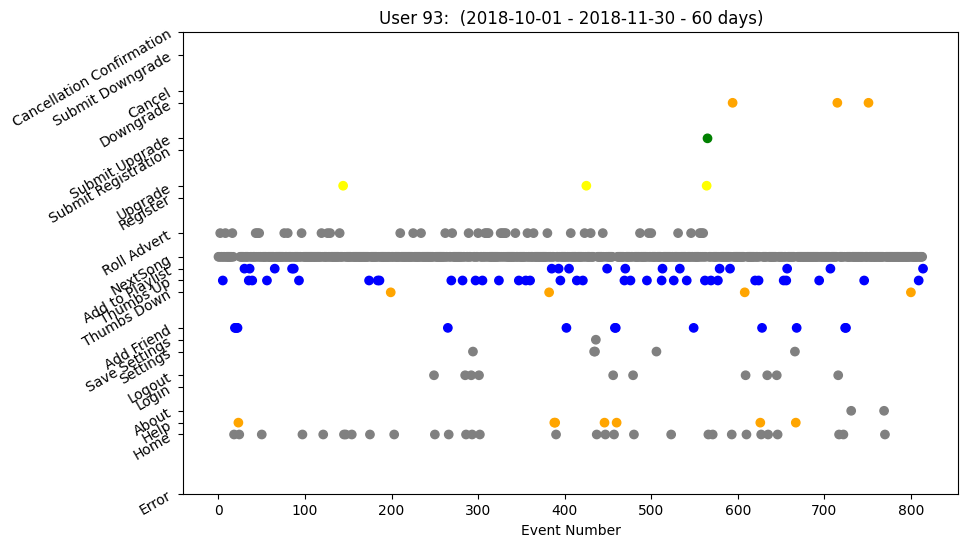

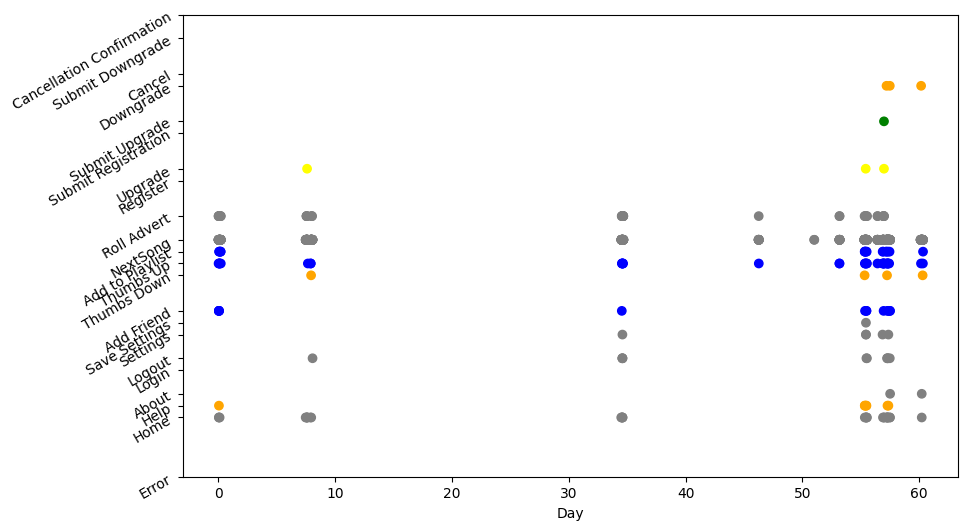

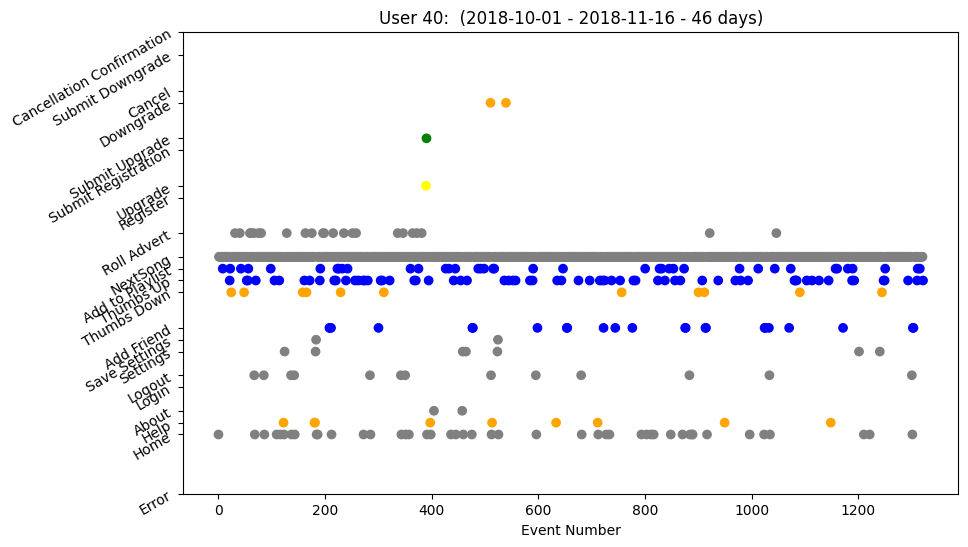

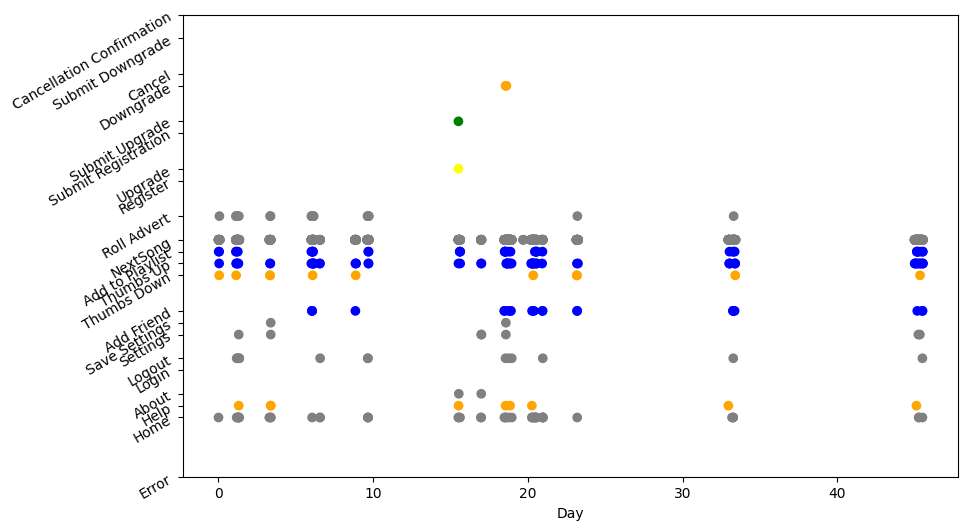

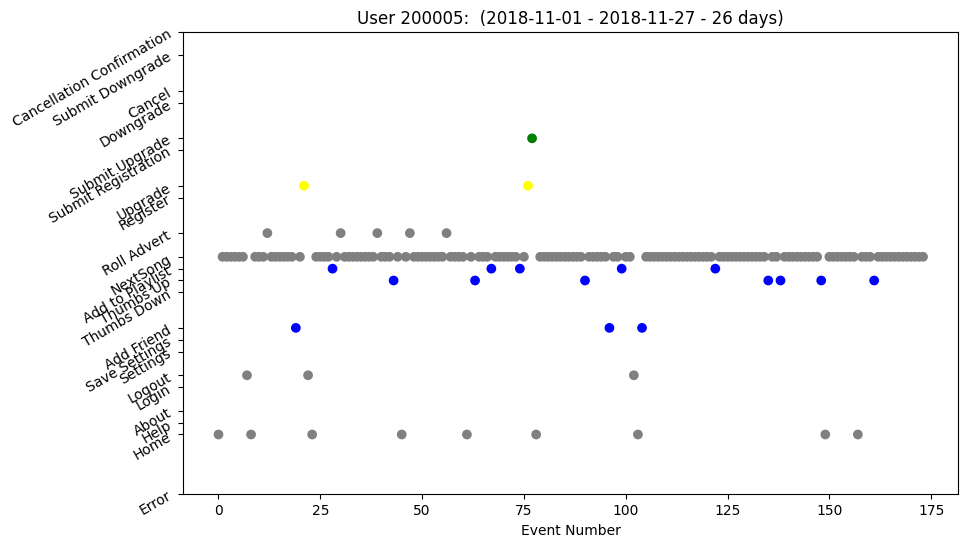

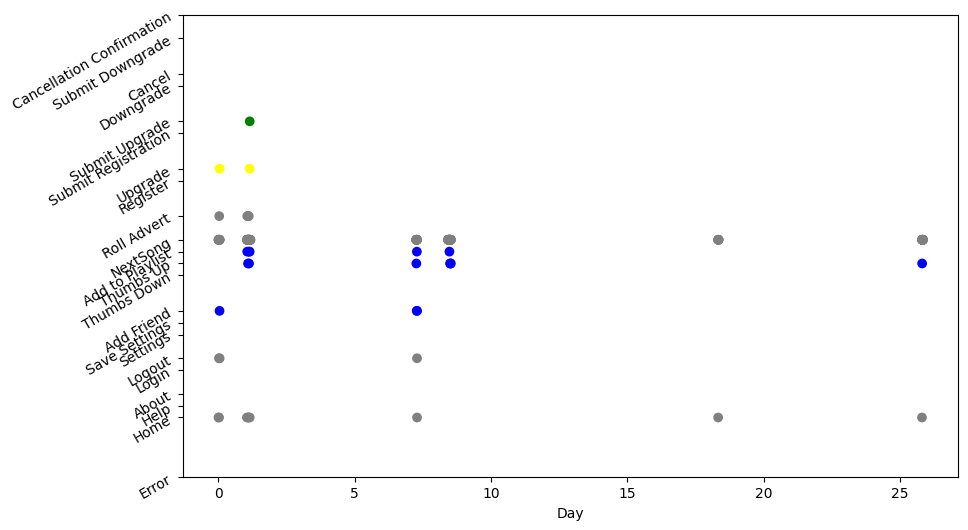

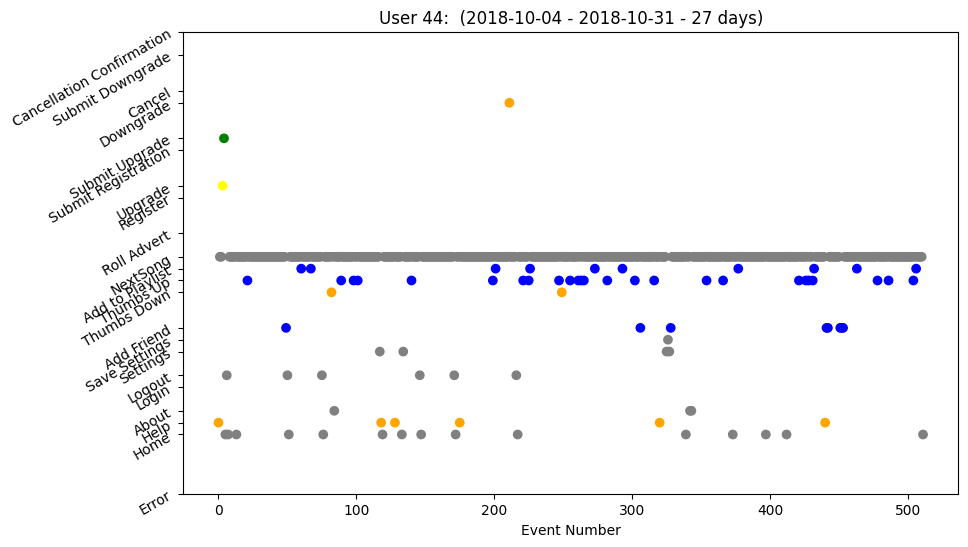

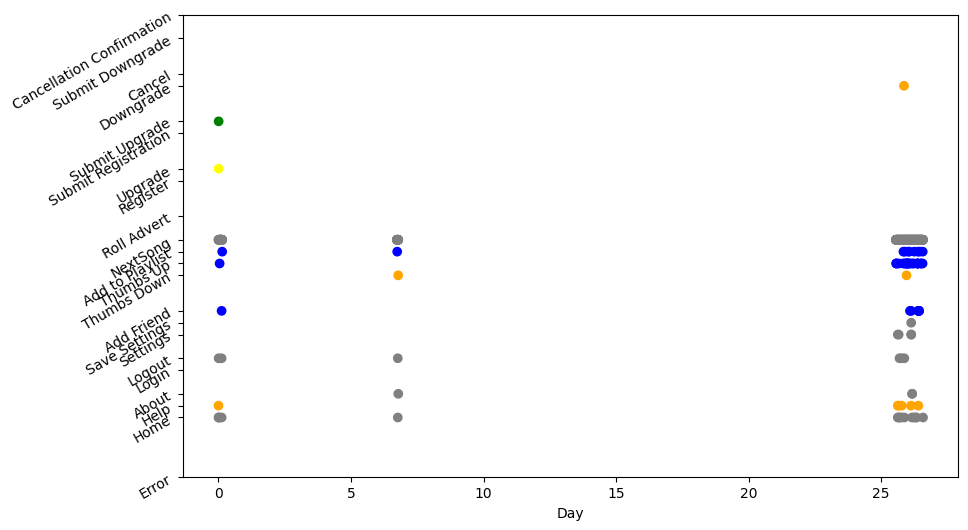

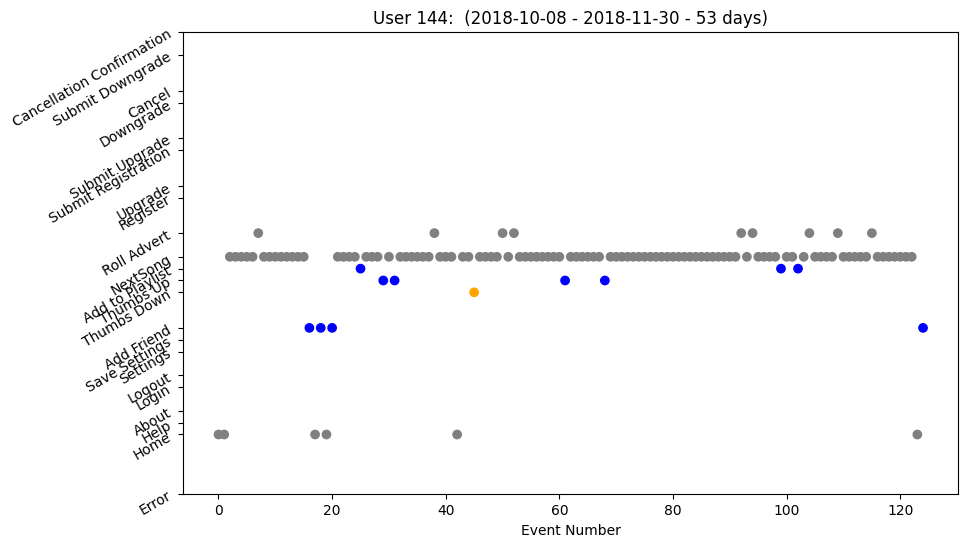

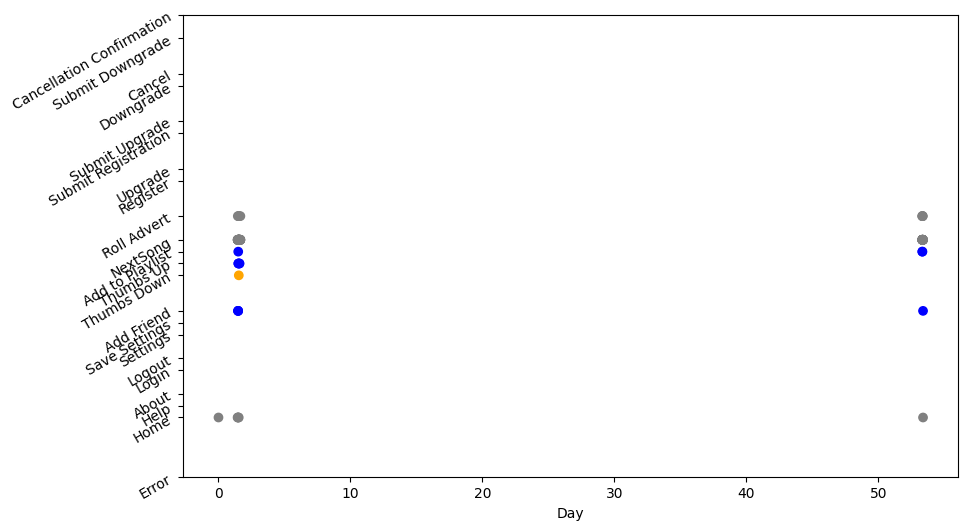

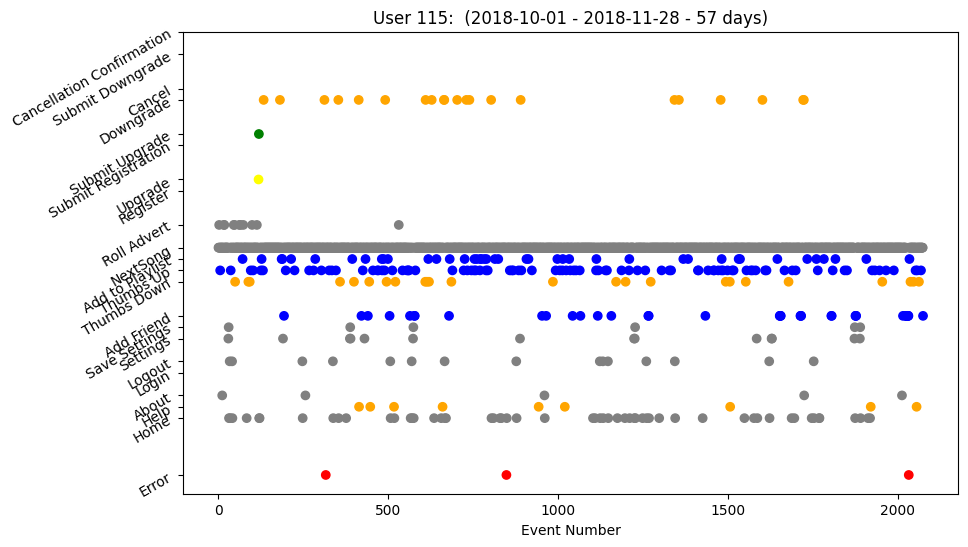

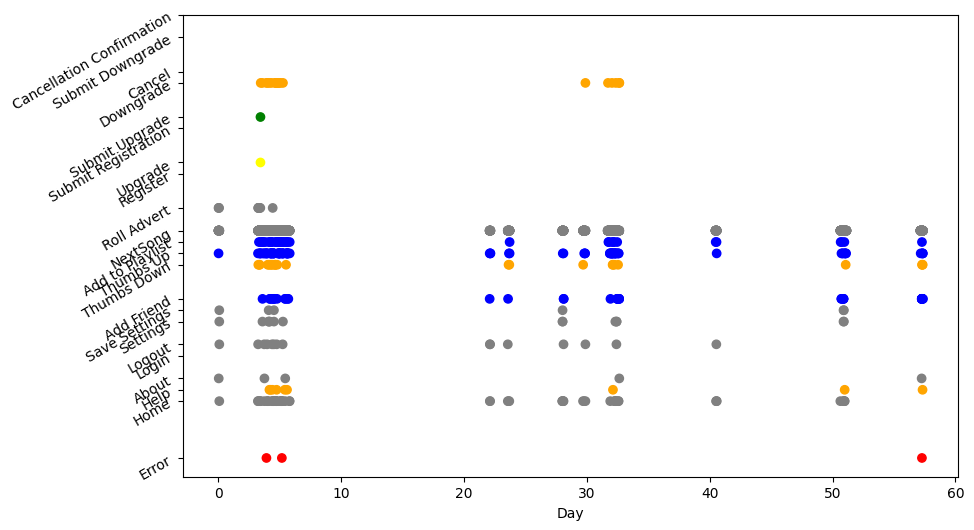

In [86]:
for uid in never_churned_users:
    plot_user_events(uid)


## Analysis

It is hard to find any "rule" for churning.

My hope was, that for example, the number of "error" page events could be related to churning.  
But for example user 124 had errors in three consecutive sessions, but did not churn.  
Also he visits the downgrade page regularly, but never commited it.  
Same is true for user 155, errors in each session a lot of "help" and "downgrade" events, but no churning.  

I expected some visual difference in the session(s) directly before the churning.  
But looking at user 51 who cancelled the subscription, there is no difference to see between the last session and the time before.  

After inspecting many users, I did not find a simple hint which directs to churning.  
But of course, there might be other (not so visible) dependencies, which can be found by the ML model.  

Maybe the diagrams are helpful later for analyzing outlayers, which are not detected.


In [87]:
print("### STOP SPARK SESSION")
spark.stop()  